# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Image Segmentation

### 1.	
Необходимо доработать обучение нейросети, что мы разбирали на уроке.(Посмотрите чего не хватает в процессе обучения и подготовки данных)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Для обхода бага библиотек

In [2]:
import torch
import torch.nn as nn
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from tqdm import tqdm
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

Часть 1. Создание модели

In [435]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, 
                                             output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, 
                                             output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, 
                                             output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, 
                                             output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        self.softmax = nn.Softmax()
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(num_features=out_channels),
                              nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        output = self.softmax(output)

        return output

Часть 2. Подготовка датасета

In [130]:
np.unique(plt.imread('C:/temp/Semantic segmentation for Self-driving Cars/dataA/dataA/CameraSeg/02_00_000.png')[:,:,0]*255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

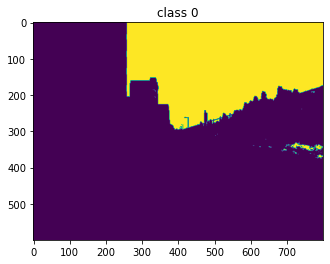

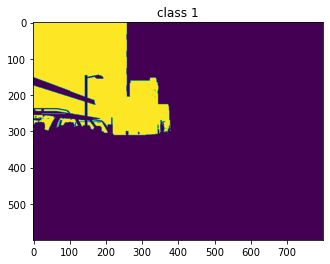

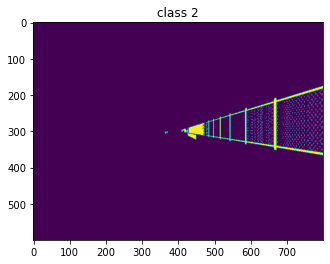

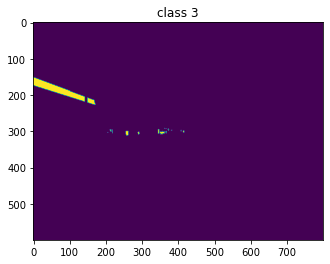

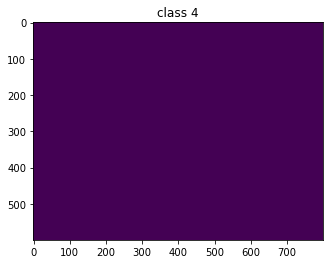

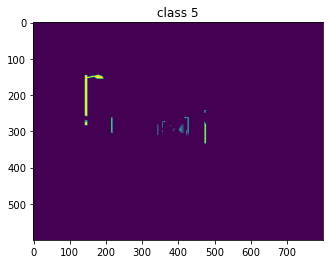

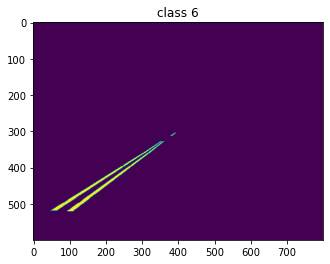

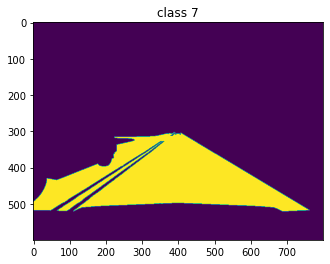

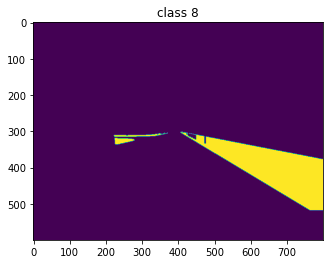

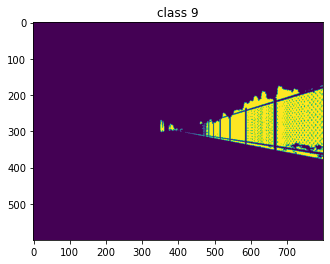

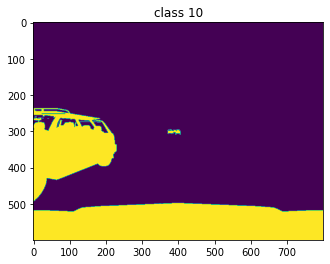

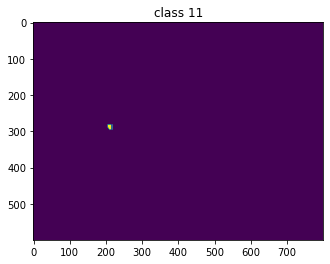

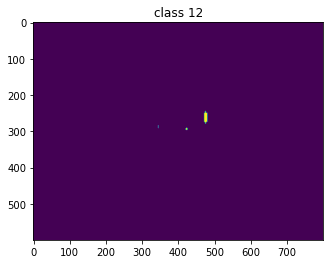

In [131]:
for i in range(13):
    mask = plt.imread('C:/temp/Semantic segmentation for Self-driving Cars/dataA/dataA/CameraSeg/02_00_000.png')*255
    mask = np.where(mask == i, 1, 0)
    mask = mask[:,:,0]
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

In [132]:
labels = ['Unlabeled','Building','Fence','Other',
          'Pedestrian', 'Pole', 'Roadline', 'Road',
          'Sidewalk', 'Vegetation', 'Car','Wall',
          'Traffic sign']

In [133]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('C:/temp/Semantic segmentation for Self-driving Cars'):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

In [134]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                           cameraRGB  \
0  C:/temp/Semantic segmentation for Self-driving...   
1  C:/temp/Semantic segmentation for Self-driving...   
2  C:/temp/Semantic segmentation for Self-driving...   
3  C:/temp/Semantic segmentation for Self-driving...   
4  C:/temp/Semantic segmentation for Self-driving...   

                                           cameraSeg  
0  C:/temp/Semantic segmentation for Self-driving...  
1  C:/temp/Semantic segmentation for Self-driving...  
2  C:/temp/Semantic segmentation for Self-driving...  
3  C:/temp/Semantic segmentation for Self-driving...  
4  C:/temp/Semantic segmentation for Self-driving...  


In [135]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        val = 1
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, val, 0)).unsqueeze(0)
        for i in range(1, 13):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            x = torch.as_tensor(np.where(mask == i, val, 0)).unsqueeze(0)
            x_out = torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [136]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [137]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

Часть 3. Обучение

In [138]:
epochs = 5

In [139]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [140]:
Umodel = UNet(num_classes=13).to(device)

In [141]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=1e-5)

In [17]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        #probs = F.sigmoid(logits) #torch.sigmoid
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
        
        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [144]:
criterion = SoftDiceLoss()

In [146]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

5 epochs, 3500 total_steps per epoch


C:\Users\rseme\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<Figure size 432x288 with 0 Axes>

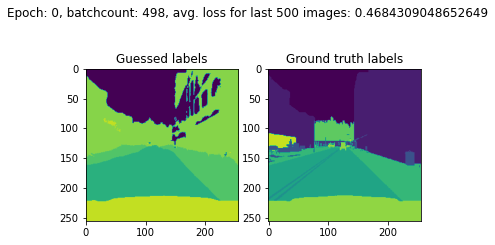

C:\Users\rseme\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

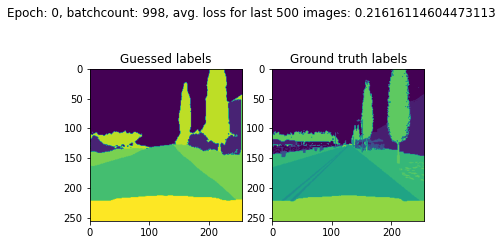

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

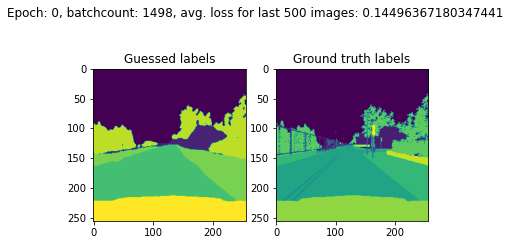

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

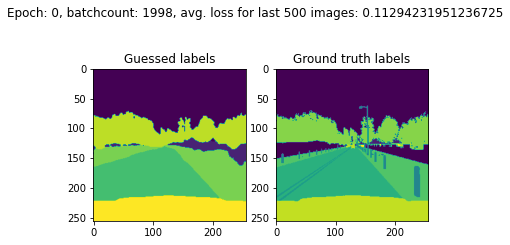

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

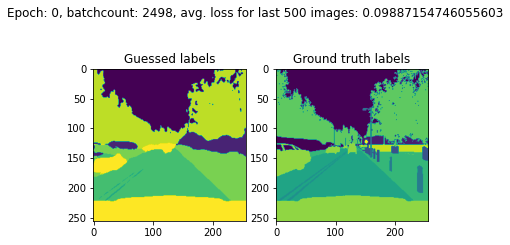

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

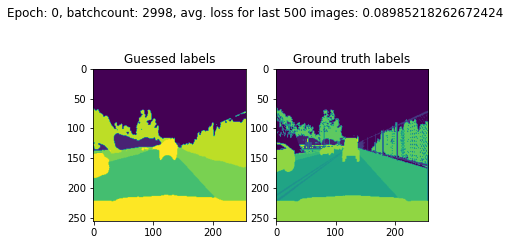

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

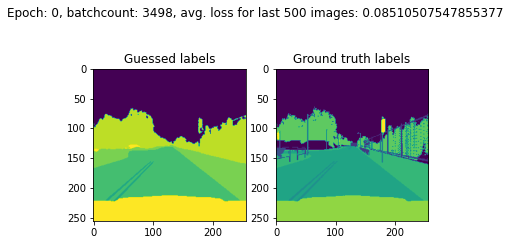

Epoch 1, loss:  0.17379191992964063


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

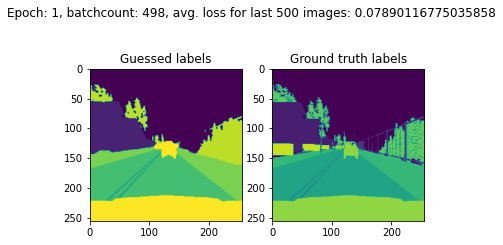

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

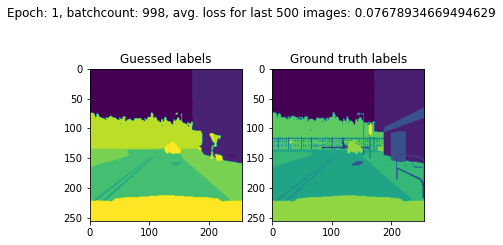

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

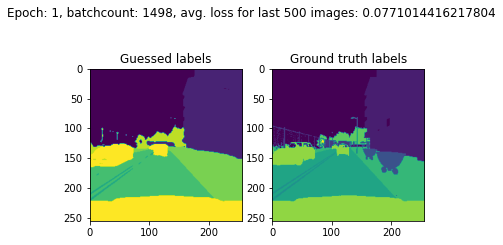

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

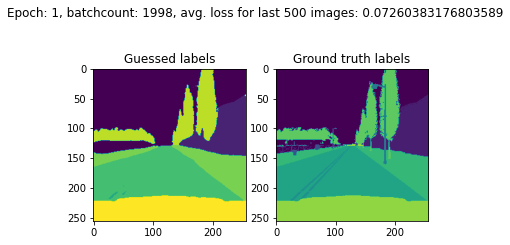

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

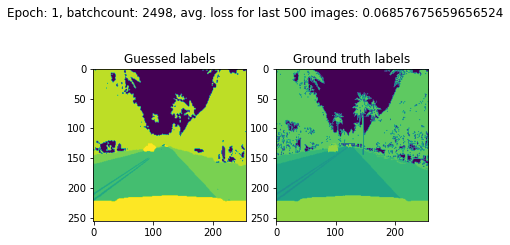

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

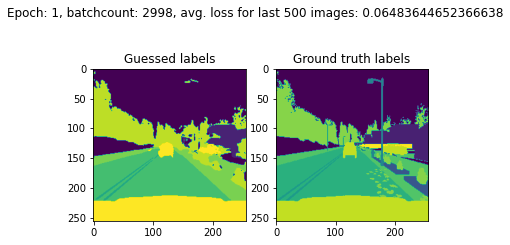

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

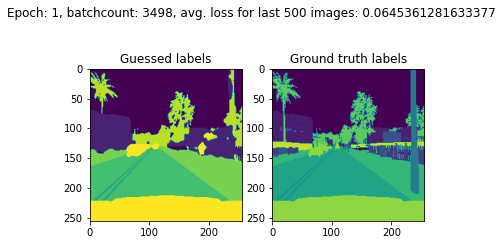

Epoch 2, loss:  0.07192492130824497


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

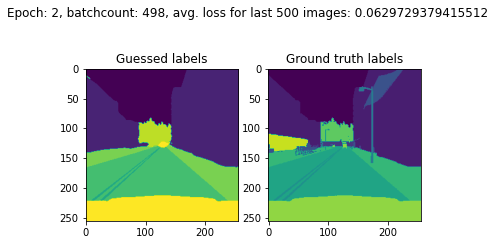

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

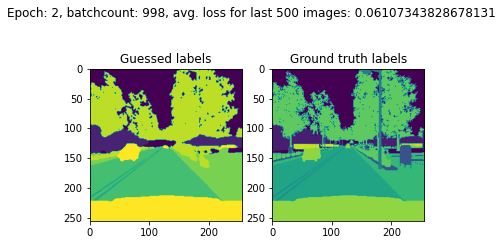

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

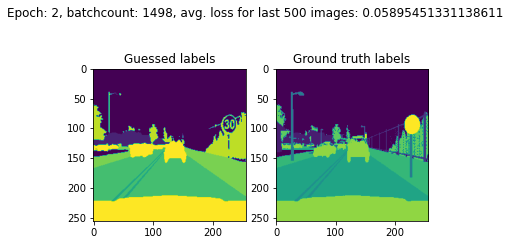

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

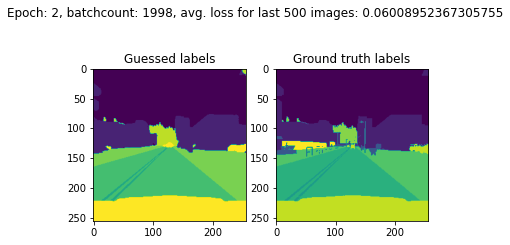

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

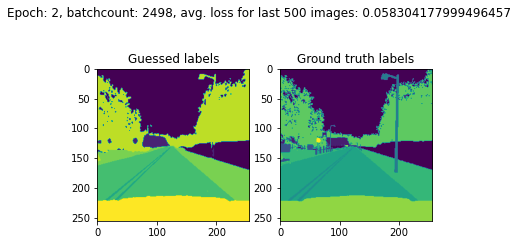

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

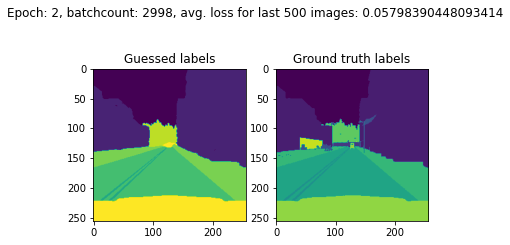

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

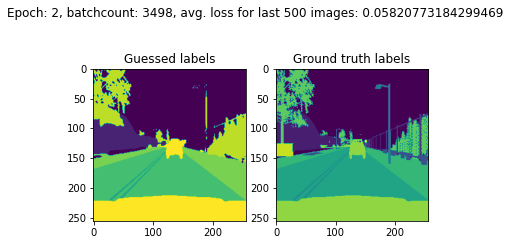

Epoch 3, loss:  0.05967148678643363


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

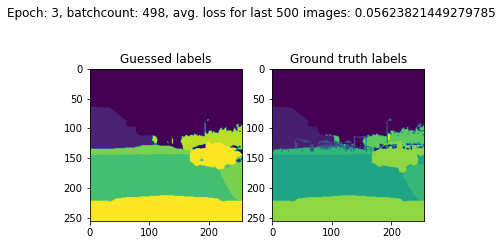

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

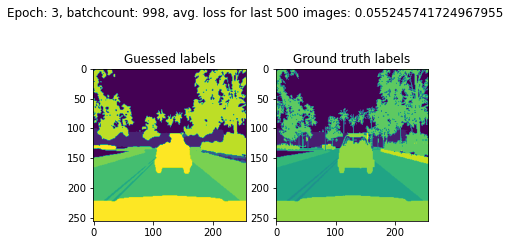

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

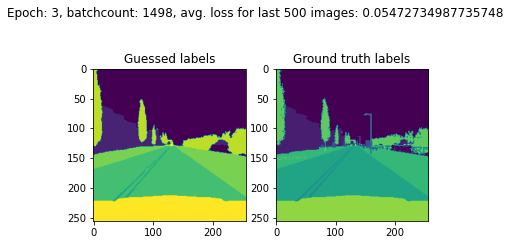

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

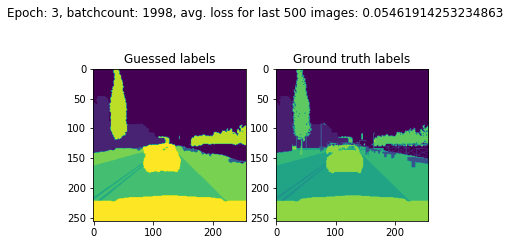

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

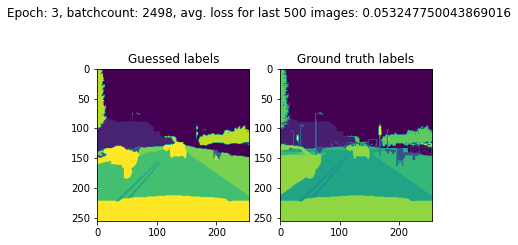

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

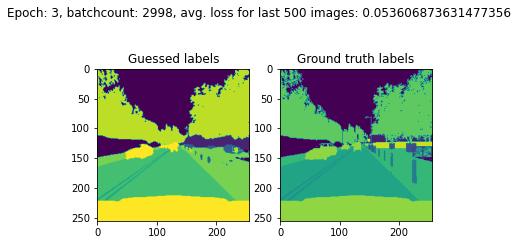

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

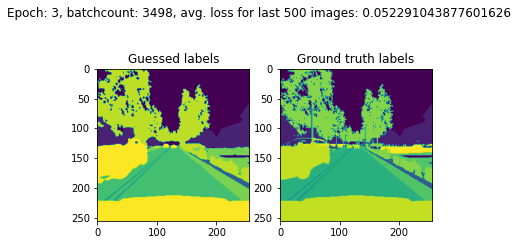

Epoch 4, loss:  0.054313211934907096


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

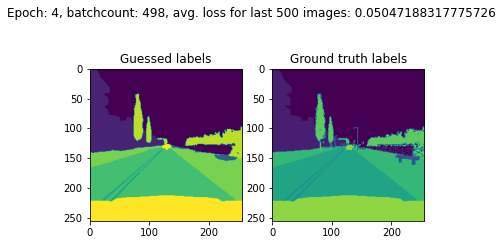

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

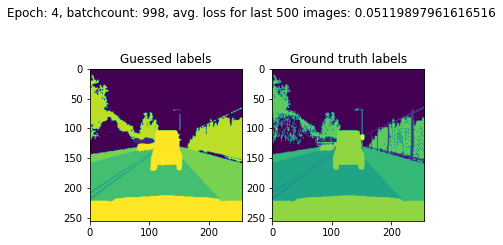

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

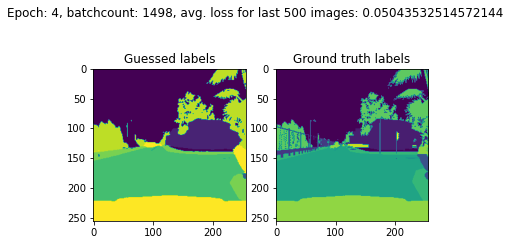

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

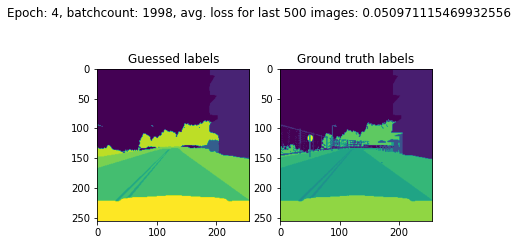

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

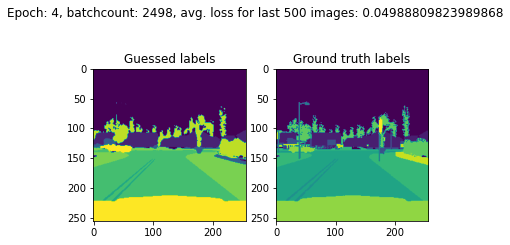

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

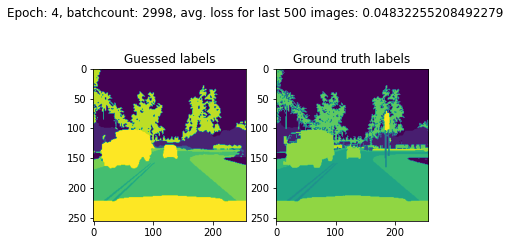

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

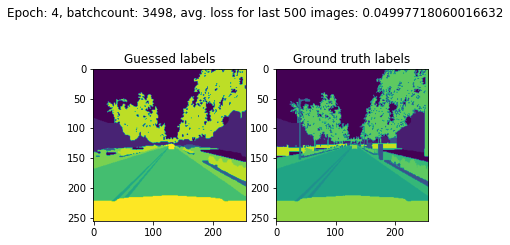

Epoch 5, loss:  0.05018725839682988
Wall time: 1h 31min 59s


<Figure size 432x288 with 0 Axes>

In [147]:
%%time
# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# Через каждые 500 итераций показываем промежуточный результат
N_OUT = 500 

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])
        loss = criterion(outputs, labels[0,:,:,:,:])
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % N_OUT == N_OUT-1:
            samp = int(np.random.randint(low=0,high=len(test_data)-1,size=1))
            with torch.no_grad():
                test = Umodel(test_data[samp][0].cuda())
            truth = test_data[samp][1]
            
            plt.figure()
            f, axarr = plt.subplots(1,2) 
            plt.suptitle(f'Epoch: {epoch}, batchcount: {batch_idx}, avg. loss for last {N_OUT} images: {running_loss/N_OUT}')
            
            axarr[0].imshow(torch.argmax(test.squeeze(), dim=0).detach().cpu().numpy())
            axarr[0].set_title('Guessed labels')
            axarr[1].imshow(torch.argmax(truth.squeeze(), dim=0))
            axarr[1].set_title('Ground truth labels')

            plt.show()
            plt.gcf().show()
            running_loss = 0.0
            
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

In [148]:
savePATH = './selfLastModel2.pth'
torch.save(Umodel.state_dict(), savePATH)

In [149]:
net=UNet(13)
net.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

Проверка на тестовых данных

C:\Users\rseme\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


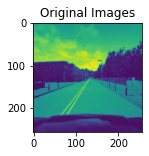

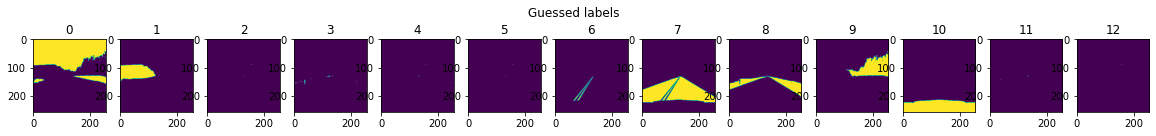

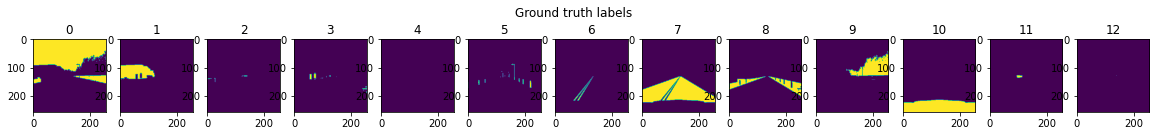

C:\Users\rseme\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 1440x144 with 0 Axes>

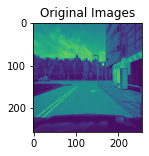

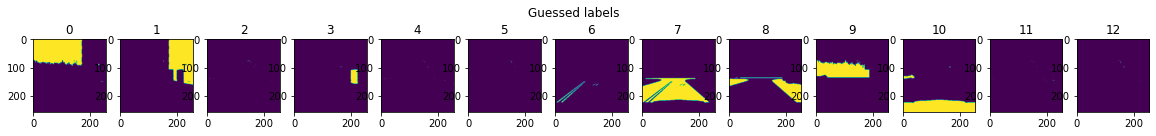

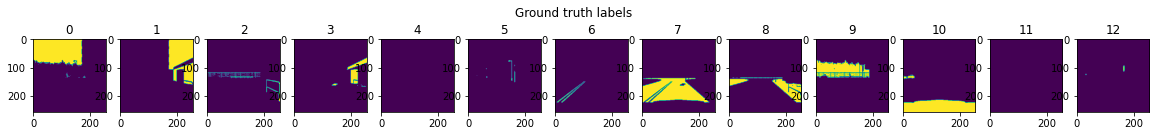

<Figure size 1440x144 with 0 Axes>

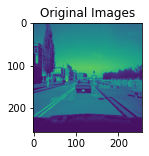

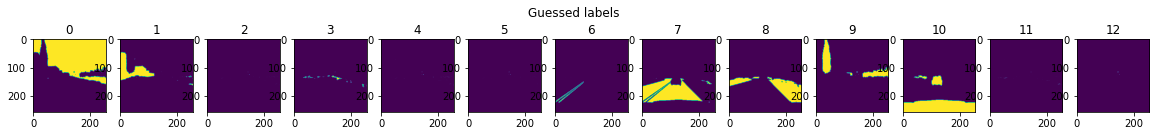

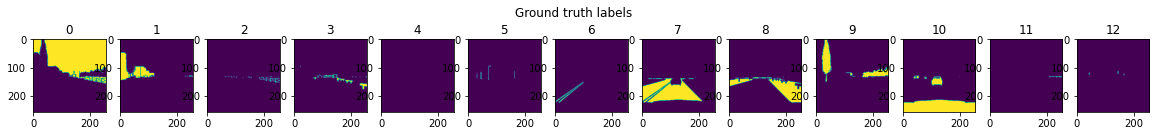

<Figure size 1440x144 with 0 Axes>

In [226]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    with torch.no_grad():
        outputs = net(images[0])

    plt.rcParams["figure.figsize"] = (2,2)
    fig, ax = plt.subplots(1)
    ax.imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    ax.set_title('Original Images')

    plt.rcParams["figure.figsize"] = (20,2)
    fig, ax = plt.subplots(1, 13)
    fig.suptitle('Guessed labels')
    
    for j in range(13):
        ax[j].imshow(outputs[0, j].detach().cpu().numpy())
        ax[j].set_title(f'{j}')
    
    plt.rcParams["figure.figsize"] = (20,2)
    fig, ax = plt.subplots(1, 13)
    fig.suptitle('Ground truth labels')
    
    for j in range(13):
        ax[j].imshow(labels[0,0,j,:].detach().cpu().numpy())
        ax[j].set_title(f'{j}')

    plt.show()
    plt.gcf().show()
    if i>=2:
        break

### 2.
Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения.
### 3.
И затем обучить Модель на выбор из segmentation_models_pytorch

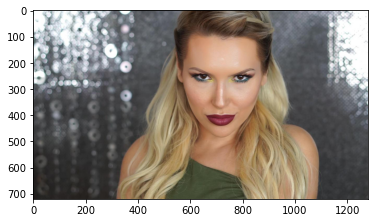

In [3]:
mask = plt.imread('C:/temp/set-lipstick-original/720p/image00000001.jpg')
plt.imshow(mask)
plt.show()

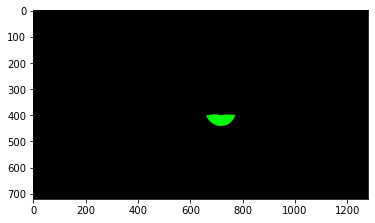

In [4]:
mask = plt.imread('C:/temp/set-lipstick-original/mask/mask00000001.png')
plt.imshow(mask)
plt.show()

In [5]:
list_csv = pd.read_csv('C:/temp/set-lipstick-original/list.csv')  
list_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [6]:
list_csv['filename'] = 'C:/temp/set-lipstick-original/720p/' + list_csv['filename']
list_csv['mask'] = 'C:/temp/set-lipstick-original/mask/' + list_csv['mask']
list_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,C:/temp/set-lipstick-original/720p/image000000...,1280,720,Lips,661,394,776,444,C:/temp/set-lipstick-original/mask/mask0000000...
1,C:/temp/set-lipstick-original/720p/image000000...,1280,720,Lips,557,336,682,392,C:/temp/set-lipstick-original/mask/mask0000000...
2,C:/temp/set-lipstick-original/720p/image000000...,1280,720,Lips,553,369,684,427,C:/temp/set-lipstick-original/mask/mask0000000...
3,C:/temp/set-lipstick-original/720p/image000000...,1280,720,Lips,555,351,681,408,C:/temp/set-lipstick-original/mask/mask0000000...
4,C:/temp/set-lipstick-original/720p/image000000...,1280,720,Lips,555,351,680,407,C:/temp/set-lipstick-original/mask/mask0000000...


In [7]:
len(list_csv)

28594

In [8]:
# Удалим строки с файлами, которые не существуют
list_csv = list_csv[list_csv.apply(lambda x: (os.path.exists(x['filename']) == True) and (os.path.exists(x['mask']) == True), 
                                   axis=1)]

In [9]:
len(list_csv)

28540

In [10]:
cameraRGB = list_csv['filename']
cameraSeg = list_csv['mask']
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
df.sort_values(by='cameraRGB', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.head(5))

                                           cameraRGB  \
0  C:/temp/set-lipstick-original/720p/image000000...   
1  C:/temp/set-lipstick-original/720p/image000000...   
2  C:/temp/set-lipstick-original/720p/image000000...   
3  C:/temp/set-lipstick-original/720p/image000000...   
4  C:/temp/set-lipstick-original/720p/image000000...   

                                           cameraSeg  
0  C:/temp/set-lipstick-original/mask/mask0000000...  
1  C:/temp/set-lipstick-original/mask/mask0000000...  
2  C:/temp/set-lipstick-original/mask/mask0000000...  
3  C:/temp/set-lipstick-original/mask/mask0000000...  
4  C:/temp/set-lipstick-original/mask/mask0000000...  


In [11]:
class CustomDatasetFromImages2(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = torch.as_tensor(img)/255    
        img = img.unsqueeze(0).permute(0,3,1,2)
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic').squeeze()
            
        lab = np.asarray(Image.open(self.label_arr[index])).astype('float')
        lab = torch.as_tensor(lab)/255    
        lab = lab.unsqueeze(0).permute(0,3,1,2)
        lab = F.interpolate(input=lab, size=256, mode='nearest').squeeze() #[0]
        
        return (img.float(), lab.float())
    
    
    def __len__(self):
        return self.data_len

In [12]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)
# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages2(X_train)
test_data = CustomDatasetFromImages2(X_test)

In [13]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [14]:
class SoftDiceLoss2(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss2, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
        
        score =2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
segmodel = smp.Unet(classes=3).to(device)
optimizer = torch.optim.Adam(segmodel.parameters(), lr=1e-3)
criterion = SoftDiceLoss2()

C:\Users\rseme\.conda\envs\tf2-gpu\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


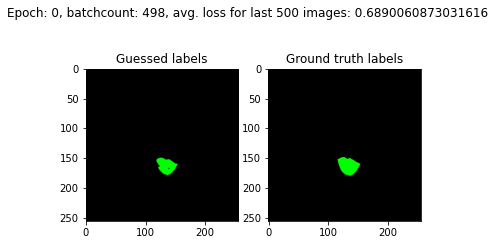

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


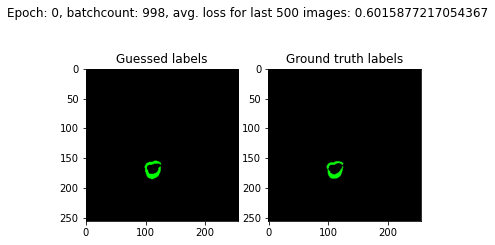

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


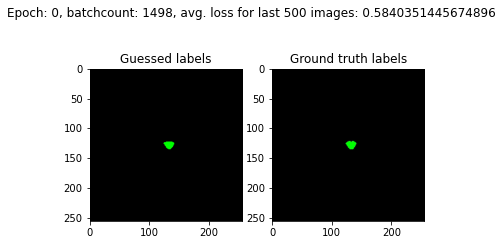

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


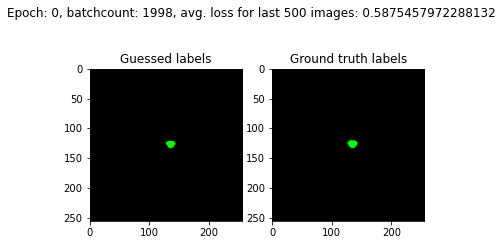

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


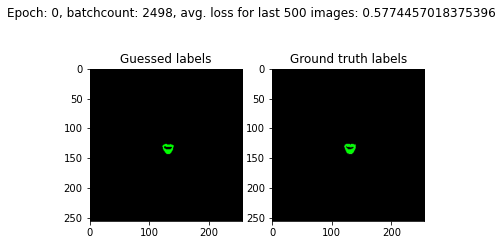

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


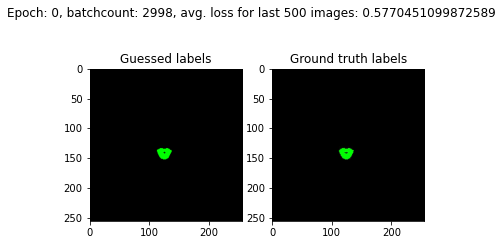

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


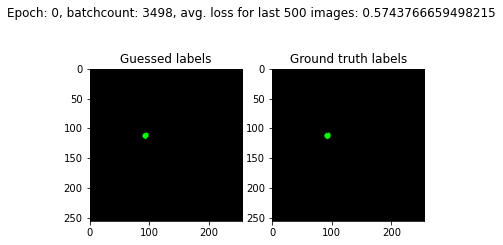

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


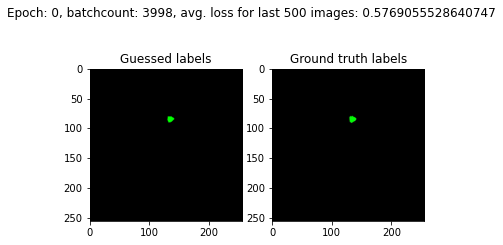

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


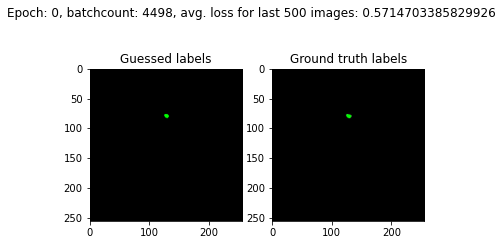

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


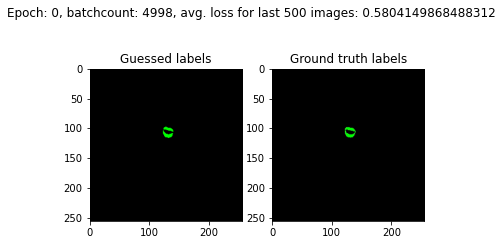

Epoch 1, loss:  0.5920964777827263  time = 440.26757550239563 sec


In [16]:
epoch_losses = []

# Через каждые 500 итераций показываем промежуточный результат
N_OUT = 500
# 5000 достаточно для обучения
N_MAX = 5000 

for epoch in range(1):
    running_loss = 0.0
    epoch_loss = []
    time1 = time.time()
    for i, data in enumerate(train_data_loader):
        if i == N_MAX:
            break
            
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = segmodel(inputs)
        loss = criterion(outputs[0],labels[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())

        if (i+1) % N_OUT == N_OUT-1:
            f, axarr = plt.subplots(1,2) 
            plt.suptitle(f'Epoch: {epoch}, batchcount: {i}, avg. loss for last {N_OUT} images: {running_loss/N_OUT}')
            axarr[0].imshow(outputs.permute(0,2,3,1).squeeze().detach().cpu().numpy())
            axarr[0].set_title('Guessed labels')
            axarr[1].imshow(labels.squeeze().permute(1,2,0).detach().cpu().numpy())
            axarr[1].set_title('Ground truth labels')
            plt.show()
            
            running_loss = 0.0
                        
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')
    epoch_losses.append(epoch_loss)

Проверка на тестовых данных

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


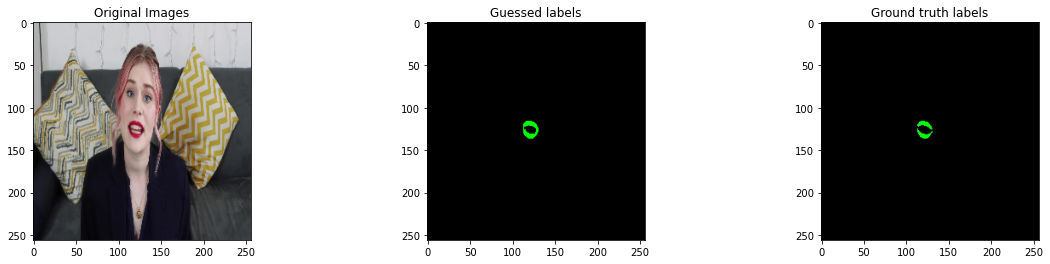

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


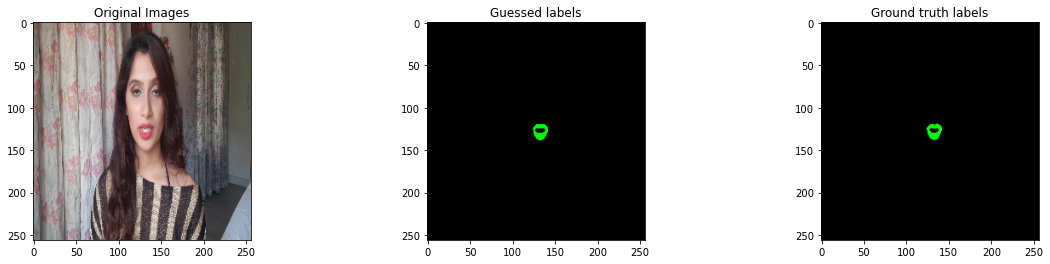

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


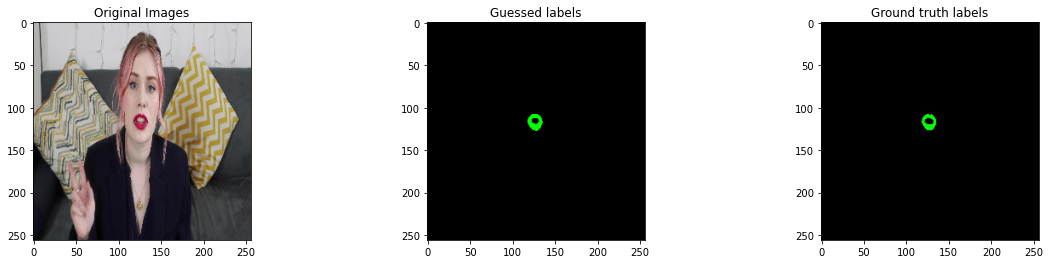

In [17]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    with torch.no_grad():
        outputs = segmodel(images.cuda())

    plt.rcParams["figure.figsize"] = (20,4)
    fig, ax = plt.subplots(1, 3)
    
    ax[0].imshow(images.permute(0,2,3,1).squeeze())
    ax[0].set_title('Original Images')

    ax[1].imshow(outputs.permute(0,2,3,1).squeeze().detach().cpu().numpy())
    ax[1].set_title('Guessed labels')
    
    ax[2].imshow(labels.permute(0,2,3,1).squeeze())
    ax[2].set_title('Ground truth labels')

    plt.show()
    if i>=2:
        break